In [1]:
import pandas as pd
import json
import os
import traceback


#load the origin set for any data cross reference needed via job_id
df_orig = pd.read_csv("job_postings.csv")

# Directory where the JSON files are stored
json_dir = 'jobjsonfiles'

# Initialize an empty list to store the data
data = []
corrupted = []

testmode = True

# Iterate over each file in the directory
for filename in os.listdir(json_dir):
    if filename.endswith('.json'):
        # Construct the full file path
        file_path = os.path.join(json_dir, filename)
        
        # Open and load the JSON file
        with open(file_path, 'r') as file:
            json_data = json.load(file)
            #print('load' +file_path )
            # Extract relevant information from the JSON object
            job_info = json_data['meta'][0]  # Assuming there's always at least one entry in 'meta'
            
              # "subjective_elements": [
              #   {
              #     "soldier_general": 100,
              #     "student_teacher": 80,
              #     "introvert_extrovert": 120
              #   }
              # ],
            
            try:
                skills_list = [skill['skill'] for skill in json_data['skills']]
                duties_list = [ duty['duty'] for duty in json_data['duties_responsibilities']]               

                # Append the extracted information to the data list
                data.append({
                    'filename': filename,
                    'job_title': job_info['job_title'],
                    'job_category': job_info['job_category'],
                    'job_class': job_info['job_class'],
                    'sector': job_info['sector'],
                    'salary': job_info['salary'],
                    'remote': job_info['remote'],
                    'skills': ', '.join(skills_list),  # Convert list of skills to a comma-separated string
                    'duties': ', '.join(duties_list),
                    'soldier_general': json_data['subjective_elements'][0]['soldier_general'],
                    'student_teacher': json_data['subjective_elements'][0]['student_teacher'],
                    'introvert_extrovert':json_data['subjective_elements'][0]['introvert_extrovert']
                })
            except:
                #print('Error: ' + filename)
                #traceback.print_exc()
                corrupted.append(file_path)
                
            
# Create a DataFrame from the aggregated data
df = pd.DataFrame(data)

# Display the DataFrame
#print(df.head())  # Display the first few rows to check the data

print(len(df))
print(len(corrupted))


13000
2602


In [2]:
df.head()

,filename,job_title,job_category,job_class,sector,salary,remote,skills,duties,soldier_general,student_teacher,introvert_extrovert
0,1004740969-Auto-CAD-Designer---Drafter.json,Auto CAD Designer / Drafter,Engineering,Designer,Structural Engineering,60000,False,"Auto CAD, MS Office proficiency",Create and design structural drafting using Au...,50,100,80
1,133114754-Marketing-Manager.json,Marketing Manager,Marketing,Manager,Marketing,85000,False,"Marketing Strategy, Team Leadership, Market An...",Develop and execute comprehensive marketing st...,100,80,120
2,133196985-Model-Risk-Auditor.json,Model Risk Auditor,Audit,Risk Auditor,Financial Services,110000,True,"Financial Services Auditing, Risk Modeling, Do...",Assess and evaluate the effectiveness of the m...,100,120,80
3,1418582485-Property-Manager.json,Property Manager,Property Management,Manager,Property Management,75000,False,"Property Management, Tenant Relations, Financi...",Oversee a diverse portfolio of properties and ...,100,100,80
4,1483357774-Lead-Editor.json,Lead Editor,Creative,Lead,Media,70000,False,"Video Editing, Project Management, Media Manag...",Edit projects from start to finish that engage...,100,80,120


In [3]:
len(corrupted)

2602

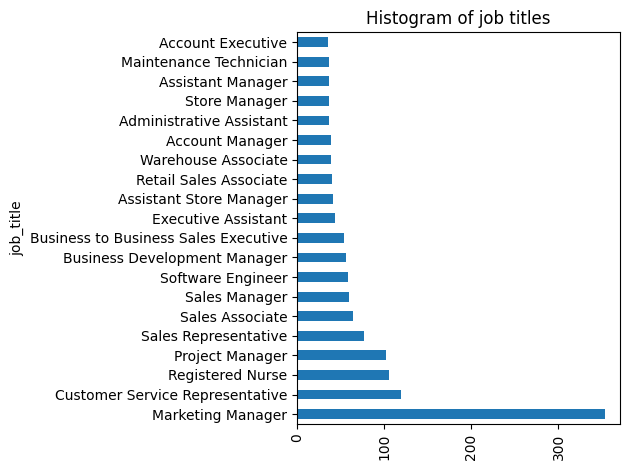

In [4]:
import matplotlib.pyplot as plt

#top 20 job titles
top20 = df['job_title'].value_counts()[0:20]



plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of job titles')
top20.plot(kind="barh")
plt.xticks(rotation=90 )
plt.tight_layout()
plt.show()


In [5]:
df['job_title'].value_counts().sum()
print( len(df['job_title'].value_counts()) )

7208


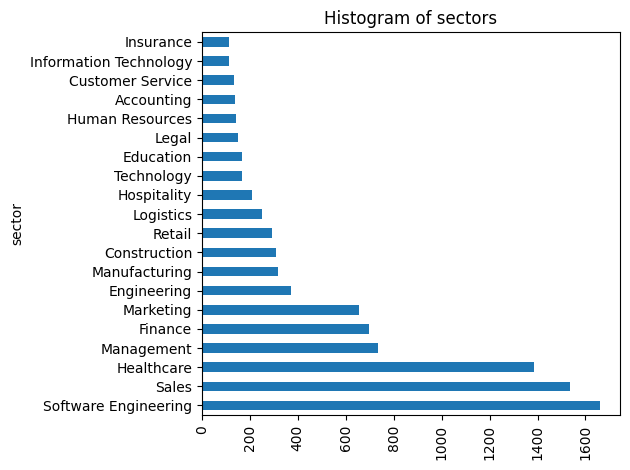

In [6]:
#top 20 sectors
top20 = df['sector'].value_counts()[0:20]



plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of sectors')
top20.plot(kind="barh")
plt.xticks(rotation=90 )
plt.tight_layout()
plt.show()

In [7]:
sector_counts = df['sector'].value_counts()
print(len(sector_counts))
sector_counts.to_csv('debug/llm_sectors.csv', index=True)


980


# TESTING! 
---------------------------------------------------------  

In [8]:
df.columns

Index(['filename', 'job_title', 'job_category', 'job_class', 'sector',
       'salary', 'remote', 'skills', 'duties', 'soldier_general',
       'student_teacher', 'introvert_extrovert'],
      dtype='object')

In [60]:
from PIL import Image, ImageDraw

def overlay_img(base_img, overlay_img_path, position):   
   
    overlay_img = Image.open(overlay_img_path)

    #alpha channel
    img_channel = None
    if overlay_img.mode == 'RGBA':
        alpha_img_channel = overlay_img    
    
    # Use the paste method to overlay the image. 
    base_img.paste(overlay_img, position, alpha_img_channel)  

    return base_img


def draw_shape(shape, img, size=(100, 100), location=(100,100), fill_color='white', stroke_color='black',stroke_width=3):
   
    draw = ImageDraw.Draw(img)
    bbox = [location[0], location[1],size[0]+location[0],size[1]+location[1]]
    #print(bbox)
    
    # Draw the specified shape
    if shape == 'circle':        
        draw.ellipse(bbox, outline=stroke_color, width=stroke_width, fill=fill_color )
        #print('draw circle')
    elif shape == 'square':        
        draw.rectangle(bbox, outline=stroke_color, width=stroke_width, fill=fill_color )
    elif shape == 'triangle':
        points = [location[0],location[1],   location[0]-size[0]/2,location[1]+size[1],    location[0]+size[0]/2, location[1]+size[1] ]
        draw.polygon(points, outline=stroke_color, width=stroke_width, fill=fill_color)
    

def create_image(row, save_path='./'):  


    #determine the location for which this needs to go:
    
    save_path = './dataset/'+str(row['clusterBresult'])  #sector
    save_path += '-'+str(row['clusterAresult']) # job
    #save_path += '-'+str(row['clusterCresult']) # duties   
            
    directory = os.path.dirname(save_path+'/')    
    #print('check for directory' ,directory )
    # Check if the directory exists, and create it if it doesn't
    if not os.path.exists(directory):
        #print('directory does not exist')
        os.makedirs(directory)

    

    
    factor = 5
    
    # shape fills
    c1_r = row["clusterAresult"] * factor
    c2_g = row["clusterBresult"] * factor
    c3_b = row["clusterCresult"] * factor
    
    #make the stroke the 0-255 inverse of the fill to add a contrasting feature within the same encoding.
    c1_r_stroke = 255-c1_r
    c2_g_stroke = 255-c2_g
    c3_b_stroke = 255-c3_b
    
    #print("background('"+str(rc1)+","+str(gc2)+","+str(bc3)+"')")
    background_color = (c1_r, c2_g, c3_b) # background based on cluster 
    # Create a new image with RGB mode, 512x512 size, and the specified background color
    
    width=128
    height=128    
    
    img = Image.new('RGB', (width, height), color=background_color)
    draw_shape("circle", img,location=(.10*width,.12*height), size=(30,30), stroke_color=(c1_r_stroke,0,0), fill_color=(c1_r,0,0))
    draw_shape("square", img, location=(.4*width,.12*height),  size=(30,30), stroke_color=(0,c2_g_stroke,0), fill_color=(0,c2_g,0))
    draw_shape("triangle", img, location=(.8*width,.12*height) ,size=(30,30),  stroke_color=(0,0,c3_b_stroke), fill_color=(0,0,c3_b))
    
    #draw subjective shapes
    st = row["student_teacher"]
    sg = row["soldier_general"]
    ie = row["introvert_extrovert"]
    
    
    draw_shape("square", img, location=(0,.8*height),  size=(width,5), fill_color=(st,st,st), stroke_width=0)
    draw_shape("square", img, location=(0,.85*height),  size=(width,5), fill_color=(sg,sg,sg),stroke_width=0)
    draw_shape("square", img, location=(0,.90*height),  size=(width,5), fill_color=(ie,ie,ie),stroke_width=0)
    
    #get the original description for this job and build a word cloud to overlay
    job_id = row['filename'].split('-')[0]
    
    #print('jobid: ' , job_id, type(job_id))
    
    word_cloud_text = df_orig[  df_orig['job_id']== int( job_id )  ]['description']
    word_cloud_text = word_cloud_text.iloc[0]+' '+row['job_title']+' '+row['job_class']
    
    img = overlay_wordcloud(word_cloud_text,img,width,height)
    
    #print( type(row['remote']) , row['remote'] )
    if(row['remote']==True):
        #print('add a star!')
        img = overlay_img(img, 'goldstar.png', ( int(0.75*width), int(.48*height)))

    #add the money cubes , our mac salary is $250,000 so we need to scale that along the top 128 px . ;
    salary_factor = 8
    try:
        salary_factor = int( ( row['salary'] / 250000 ) * width )
    except:
        print('error - bad salary on '+row['filename'])
    box_count = int(salary_factor / 8)
    box_width = 7
    stroke_width = 1
    
    for boxIndex in range(0,box_count):
        draw_shape("circle", img, location=(boxIndex*8,.03*height),  size=(7,7), fill_color=(0,255,0),stroke_width=stroke_width)
    
    

   
    
    # Save the image to a file
    img.save(save_path+'/' +row['job_title'].replace('/','-')+'.png')


## Note direct below is just testing.

In [11]:
from random import randint

managers =  df[ df['sector']=='Management'][0:100]
programmers =  df[ df['sector']=='Software Engineering'][0:100]

managers['clusterAresult'] = 1
managers['clusterBresult'] = 1
managers['clusterCresult'] = 1


managers['clusterAresult']  = managers['clusterAresult'].apply( lambda x: randint(0, 25)  )
managers['clusterBresult'] = managers['clusterBresult'].apply( lambda x: randint(0, 25)  )
managers['clusterCresult'] = managers['clusterCresult'].apply( lambda x: randint(0, 25)  )

#print(managers.head())

programmers['clusterAresult'] = 1
programmers['clusterBresult'] = 1
programmers['clusterCresult'] = 1

programmers['clusterAresult'] =  programmers['clusterAresult'].apply( lambda x: randint(30,40)  )
programmers['clusterBresult'] =  programmers['clusterBresult'].apply( lambda x: randint(30,40)   )
programmers['clusterCresult'] =  programmers['clusterCresult'].apply( lambda x: randint(30,40)  )

#managers.apply(create_image, axis=1, args=('dataset/managers',))
#programmers.apply(create_image, axis=1, args=('dataset/programmers',))



In [12]:
managers[ ['job_title','clusterAresult','clusterBresult','clusterCresult'] ][0:3]


,job_title,clusterAresult,clusterBresult,clusterCresult
20,Head of Talent Acquisition,14,25,3
43,Executive Assistant,17,8,9
51,Executive Assistant to Founder,21,22,1


In [13]:
programmers[ ['job_title','clusterAresult','clusterBresult','clusterCresult'] ][0:3]



,job_title,clusterAresult,clusterBresult,clusterCresult
13,ITOps ServiceNow Admin,39,38,34
14,Salesforce Platform Manager,34,35,30
23,Lead Software Engineer,40,33,33


---------------------------------------------------------  Testing above Make sure to comment out.

In [14]:
# here we want to build the BERT vectors that will be used for clustering

# load BERT
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")




C:\git\LondonCS\CM3060-NLP\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


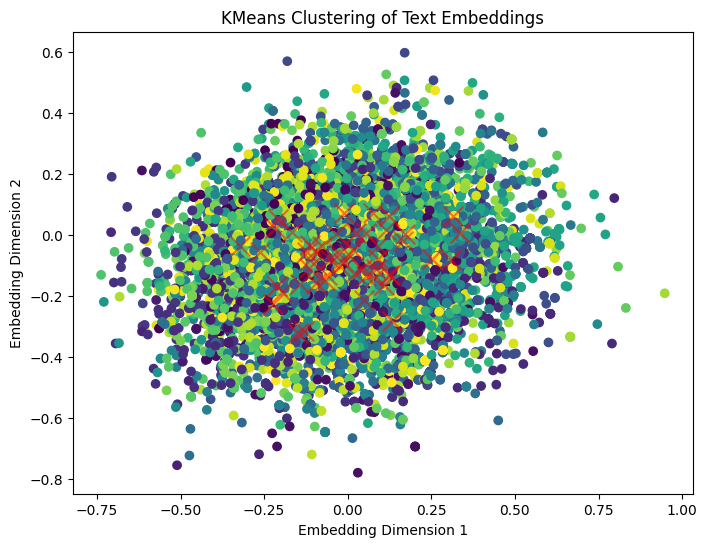

In [15]:

# Define two classes of texts
texts = ["Expertise in Python, machine learning, and data analysis.",
         "Able to read construction drawings" ,# Class 1
         "Proficient in web development, JavaScript, and React."]     # Class 2

# create embeddings from the job titles + sectors
#df['clusterAinput'] = df['job_title'] + ' ' + df['sector'] 
df['clusterAinput'] = df['job_title'] 




embeddings = []

# Iterate over the DataFrame rows
with torch.no_grad():
    for index, row in df.iterrows():
        # Perform operation on each row
        inputs = tokenizer(row["clusterAinput"], return_tensors="pt", padding=True, truncation=True, max_length=512)
        outputs = model(**inputs)
        embeddings.append(outputs.last_hidden_state.mean(dim=1).squeeze().numpy())

# Convert list of embeddings into an array for KMeans
embeddings_array = np.array(embeddings)

# Run KMeans with 2 clusters
kmeans = KMeans(n_clusters=51, random_state=0).fit(embeddings_array)

# Visualization
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_array[:, 0], embeddings_array[:, 1], c=kmeans.labels_, cmap='viridis', marker='o')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5, marker='x')
plt.title("KMeans Clustering of Text Embeddings")
plt.xlabel("Embedding Dimension 1")
plt.ylabel("Embedding Dimension 2")
plt.show()


C:\git\LondonCS\CM3060-NLP\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


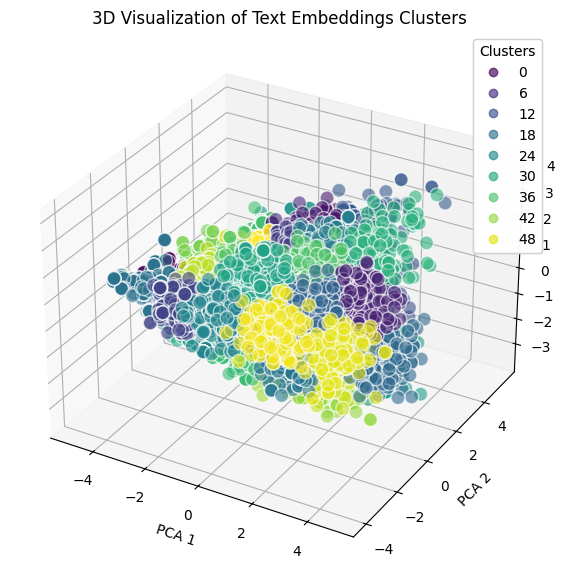

In [16]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D


# Assuming `embeddings_array` is your array of BERT embeddings
# Reduce to 3 dimensions for 3D visualization
pca = PCA(n_components=3)
reduced_embeddings = pca.fit_transform(embeddings_array)
clusters = kmeans.fit_predict(reduced_embeddings)

# Plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for each cluster
scatter = ax.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], reduced_embeddings[:, 2],
                     c=clusters, cmap='viridis', marker='o', s=100, alpha=0.6, edgecolors='w')

# Labeling the axes
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')

# Legend
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.title("3D Visualization of Text Embeddings Clusters")
plt.show()

In [17]:
# next we want to assign mback the clusters to the input data and then get some idea of the text frequency of the groups of those titles.
# Those titles will be used for style name association.
cluster_labels =  kmeans.labels_ 
df["clusterAresult"] = cluster_labels



In [18]:
df[ ["job_title", "clusterAresult"]].sample(100).sort_values(by='clusterAresult')

,job_title,clusterAresult
11216,Regulatory Affairs Coordinator,1
1919,Production Operations Analyst,1
4097,Search Engine Analyst,2
7937,Logistics Specialist,4
2999,Quantitative Analyst,4
...,...,...
1232,GCP Data lead/Architect,48
1583,Operations Technician,50
1370,RF Engineer,50
6190,Dispatcher,50


In [19]:
df[ df["clusterAresult"]==40].sample(20)

,filename,job_title,job_category,job_class,sector,salary,remote,skills,duties,soldier_general,student_teacher,introvert_extrovert,clusterAinput,clusterAresult
6663,3697366081-Truck-Driver.json,Truck Driver,Transportation,Driver,Logistics,50000,False,"Safe Driving, Customer Service, Material Handl...",Transport goods and supplies onsite and offsit...,120,80,60,Truck Driver,40
5818,3694131711-Truck-Driver.json,Truck Driver,Transportation,Driver,Logistics,47000,False,"CDL-A License, Spotter Truck Driving, Safe dri...",Drive spotter truck and/or day cab within the ...,100,60,80,Truck Driver,40
9526,3699404463-Lab-Technician.json,Lab Technician,Medical,Technician,Healthcare,30000,False,"Laboratory Testing, Good Laboratory Practices ...",Assist in testing of patient samples according...,100,50,150,Lab Technician,40
6339,3697355824-Test-Engineer.json,Test Engineer,Engineering,Engineer,Software Engineering,85000,False,"Test Equipment Installation, Test Equipment Qu...",Coordinates the installation of production tes...,50,100,80,Test Engineer,40
2297,3693058155-School-Counselor.json,School Counselor,Education,Counselor,Education,55000,False,"Counseling, Interpersonal Skills, Time Managem...",Provide guidance and resources to middle and h...,40,140,180,School Counselor,40
12188,3701323160-Superintendent.json,Superintendent,Construction,Manager,Management,90000,False,"Construction Management, Project Management, S...",Leads all aspects of the company’s safety cult...,100,100,80,Superintendent,40
1016,3693047353-Design-Engineer.json,Design Engineer,Engineering,Engineer,Mechanical,80000,False,"CAD Design, Heavy Machinery Design, PLM Data M...",Design complex components and sub-systems for ...,150,100,130,Design Engineer,40
10402,3700556102-Biologist.json,Biologist,Science,Staff,Environmental,75000,False,"Biological Survey, Field Data Collection, Envi...",Conduct biological natural resource field surv...,100,70,80,Biologist,40
9806,3699413087-Nursing-Assistant.json,Nursing Assistant,Healthcare,Assistant,Healthcare,32000,False,"Clerical Tasks, Record Keeping, Organizational...","Perform clerical and receptionist duties, incl...",60,40,80,Nursing Assistant,40
5931,3694155000-Maintenance-Supervisor.json,Maintenance Supervisor,Vehicle Maintenance Management/Supervisors,Supervisor,Operations,63000,False,"Fleet Maintenance Management, Team Management,...",Prioritize and assign work to meet customers’ ...,100,120,80,Maintenance Supervisor,40


In [20]:
# ok that works we can create the colors as needed .  repeat for skills clusters

# build the embeddings for concatenated skills

# create embeddings from the job titles + sectors
#df['clusterBinput'] = df['skills'].replace(",", " ")
df['clusterBinput'] = df['sector'] 
embeddings = []

# Iterate over the DataFrame rows
with torch.no_grad():
    for index, row in df.iterrows():
        # Perform operation on each row
        inputs = tokenizer(row["clusterBinput"], return_tensors="pt", padding=True, truncation=True, max_length=512)
        outputs = model(**inputs)
        embeddings.append(outputs.last_hidden_state.mean(dim=1).squeeze().numpy())

# Convert list of embeddings into an array for KMeans
embeddings_array = np.array(embeddings)

C:\git\LondonCS\CM3060-NLP\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


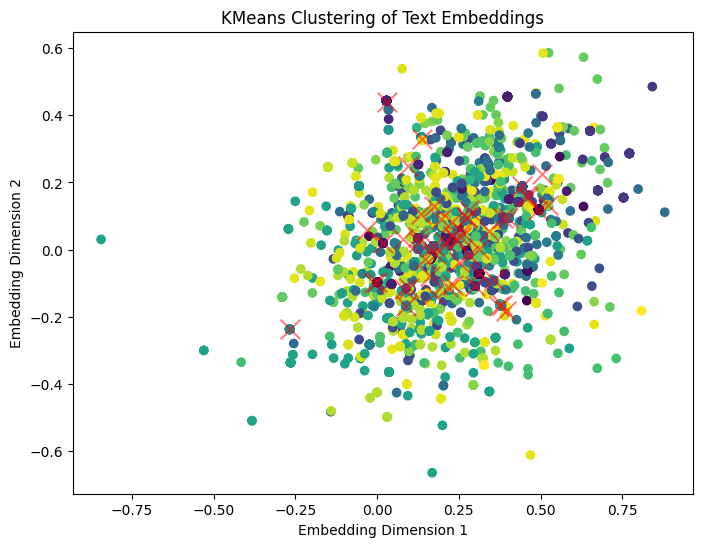

In [21]:
# Run KMeans with 51 clusters
kmeans = KMeans(n_clusters=51, random_state=0).fit(embeddings_array)

# Visualization
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_array[:, 0], embeddings_array[:, 1], c=kmeans.labels_, cmap='viridis', marker='o')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5, marker='x')
plt.title("KMeans Clustering of Text Embeddings")
plt.xlabel("Embedding Dimension 1")
plt.ylabel("Embedding Dimension 2")
plt.show()

C:\git\LondonCS\CM3060-NLP\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


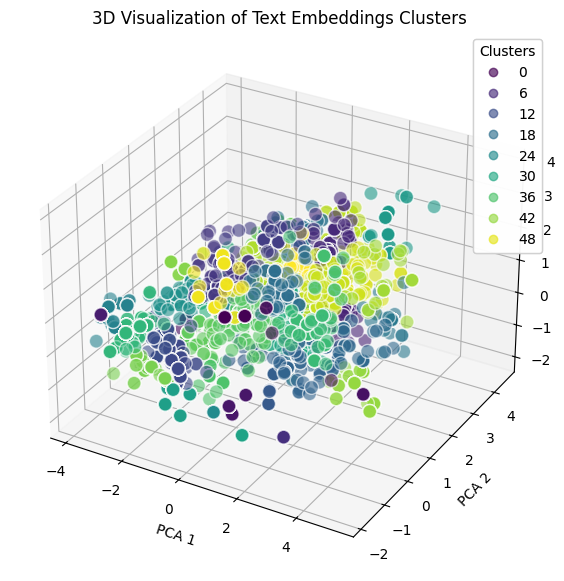

In [22]:

# Assuming `embeddings_array` is your array of BERT embeddings
# Reduce to 3 dimensions for 3D visualization
pca = PCA(n_components=3)
reduced_embeddings = pca.fit_transform(embeddings_array)
clusters = kmeans.fit_predict(reduced_embeddings)

# Plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for each cluster
scatter = ax.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], reduced_embeddings[:, 2],
                     c=clusters, cmap='viridis', marker='o', s=100, alpha=0.6, edgecolors='w')

# Labeling the axes
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')

# Legend
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.title("3D Visualization of Text Embeddings Clusters")
plt.show()

In [23]:
cluster_labels =  kmeans.labels_ 
df["clusterBresult"] = cluster_labels

df[ df["clusterBresult"]==10].sample(30)['job_title']

5937                            Science Research Tutor
7184     Senior Design Engineer - Water Infrastructure
3073                       Speech Language Pathologist
10059                                     CARE Liaison
80                                M&A Project Director
1619                               Assistant Professor
2297                                  School Counselor
1690                      Education & Outreach Manager
8531                                  AP Physics Tutor
6153                               Sports Statistician
2490                                Content Specialist
10446                        Special Education Teacher
34                            Children's Music Teacher
12006                     External CLASS Data Assesors
6186                         Special Education Teacher
5557                   Dean of Business and Technology
12999                             Manager of Education
6515                      Youth Development Specialist
9393      

In [24]:
df[ df["clusterBresult"]==0].sample(10)['job_title']


4589      Customer Relations Specialist
6212                Lift Truck Operator
11671    Warehouse Operations Associate
3777                Warehouse Associate
5679     Warehouse Receiving Supervisor
10336        Senior Engineering Manager
462                   Sample Specialist
10317        Senior Engineering Manager
9994                  Forklift Operator
10318        Senior Engineering Manager
Name: job_title, dtype: object

In [25]:
# build the embeddings for concatenated duties

# create embeddings from the job titles + sectors
df['clusterCinput'] = df['duties']
embeddings = []

# Iterate over the DataFrame rows
with torch.no_grad():
    for index, row in df.iterrows():
        # Perform operation on each row
        inputs = tokenizer(row["clusterCinput"], return_tensors="pt", padding=True, truncation=True, max_length=512)
        outputs = model(**inputs)
        embeddings.append(outputs.last_hidden_state.mean(dim=1).squeeze().numpy())

# Convert list of embeddings into an array for KMeans
embeddings_array = np.array(embeddings)

C:\git\LondonCS\CM3060-NLP\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


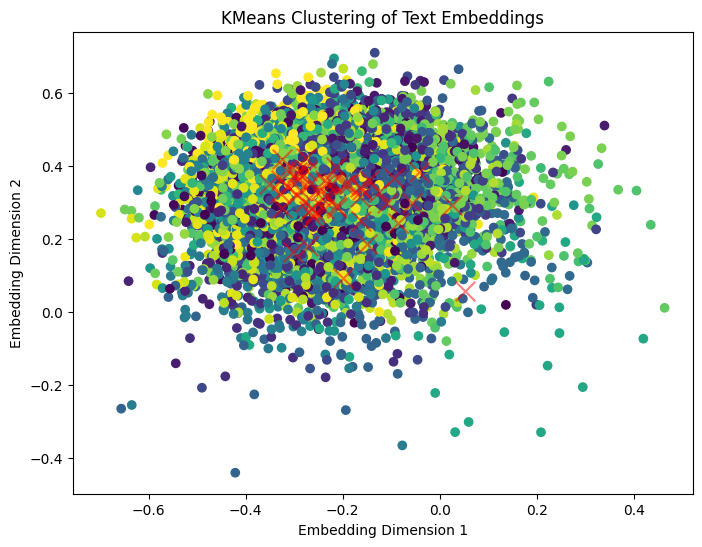

In [26]:
# Run KMeans with 2 clusters
kmeans = KMeans(n_clusters=51, random_state=0).fit(embeddings_array)

# Visualization
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_array[:, 0], embeddings_array[:, 1], c=kmeans.labels_, cmap='viridis', marker='o')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5, marker='x')
plt.title("KMeans Clustering of Text Embeddings")
plt.xlabel("Embedding Dimension 1")
plt.ylabel("Embedding Dimension 2")
plt.show()

C:\git\LondonCS\CM3060-NLP\env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


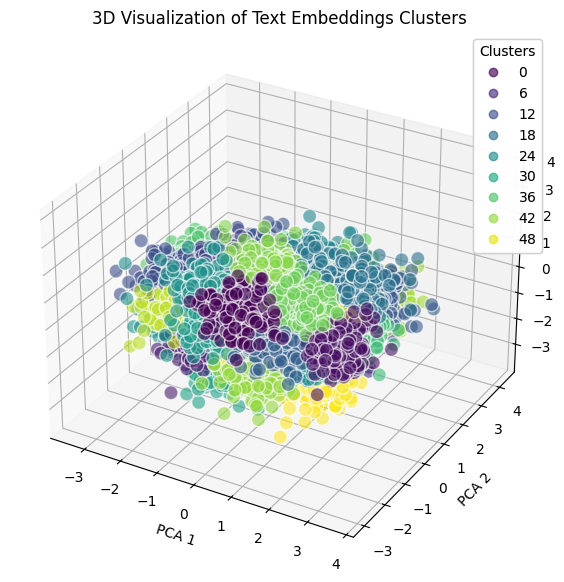

In [27]:
# Assuming `embeddings_array` is your array of BERT embeddings
# Reduce to 3 dimensions for 3D visualization
pca = PCA(n_components=3)
reduced_embeddings = pca.fit_transform(embeddings_array)
clusters = kmeans.fit_predict(reduced_embeddings)

# Plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for each cluster
scatter = ax.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], reduced_embeddings[:, 2],
                     c=clusters, cmap='viridis', marker='o', s=100, alpha=0.6, edgecolors='w')

# Labeling the axes
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')

# Legend
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.title("3D Visualization of Text Embeddings Clusters")
plt.show()

In [28]:
# Analyze the groupings, do they make sense?

cluster_labels =  kmeans.labels_ 
df["clusterCresult"] = cluster_labels

df[   df["clusterCresult"]==10].sample(20)['job_title']

1217                              Clinical Manager
9010          Biomedical Engineering Technician II
12169                 Business Services Accountant
12166                       Operational Controller
9493        Graduate Medical Education Coordinator
9074                            Research Scientist
6385                       Director of Engineering
7704                      Field Service Technician
7488                      Field Service Technician
2301                         Automotive Technician
11290                       Maintenance Supervisor
9146                          Staff Hydrogeologist
3375              Residential Construction Foreman
9854     Plant Operations and Maintenance Director
2028                             Warehouse Manager
8283                                Chief Engineer
6643                 Nuclear Medicine Technologist
1213                          Maintenance Mechanic
6482                                      Engineer
5487                       Spar

In [29]:
df[ df["clusterCresult"]==0].sample(50)['job_title']

2697            Assistant Nurse Manager, Specialty Clinics
3642                       Licensed Clinical Social Worker
10425                           Religious Program Director
9091                                  Receiving Supervisor
2732                            RN 2 - Hematology/Oncology
10326                    Acute Care Float Registered Nurse
10304                                     Registered Nurse
6383                                         Social Worker
5551                                       Ramp Supervisor
9879                                                 Nurse
4488                           Ambulatory Nursing Educator
10199                                Respiratory Therapist
9981                                  Clinical Coordinator
908                             Associate Medical Director
9398                            Advanced Practice Provider
3399                         Director of Clinical Programs
6542                                      Registered Nur

In [30]:
from wordcloud import WordCloud

def overlay_wordcloud(text, background_image,width, height):
    # Generate a word cloud image
    #text = "Python data science machine learning deep learning neural networks visualization"
    wordcloud = WordCloud(width=400, height=200, background_color='white', mode='L', colormap='gray').generate(text)

    # Convert to PIL Image
    wc_image = wordcloud.to_image()

    # Make the word cloud image black and white
    wc_image = wc_image.convert('1')  # Convert to binary image (black and white)    

    # Optional: Resize word cloud image if needed
    #wc_image = wc_image.resize((400, 200), Image.ANTIALIAS)
    wc_image = wc_image.resize(( int(width*.7), int(height*.3)), Image.Resampling.LANCZOS)


    # Paste the word cloud onto the background image
    # Specify the top-left corner for pasting the word cloud
    position = (0, int(height*.45))  # Change as needed
    background_image.paste(wc_image, position, wc_image)

    return background_image
    

#     # Display the resulting image
#     plt.imshow(background_image)
#     plt.axis("off")
#     plt.show()

In [31]:
# Ok now that it is working , it is time to generate the images from the clusters.   We will need to make sure to re-run all this and append in the jobid to retrieve the original json file.
# The reason is because the original json file contains the subjective higher dimensial features we need to artistically blend in

# lets prototype this on 100 images

# Image rules:
# there are 51 clusters for each cluster category - RGB for increments of 5.
# The left stripe box is a a combination of all colors > one RGB value
# Then  3 circles for RGB color shades of sole color silo amounts.

# first cluster is from job title sector embeddings
# second cluster is from  skills embeddings
# third cluster is from duties & responibilities 




In [61]:
df.columns


            
df.apply(create_image, axis=1)
    

error - bad salary on 3693046171-Account-Executive.json


0        None
1        None
2        None
3        None
4        None
         ... 
12995    None
12996    None
12997    None
12998    None
12999    None
Length: 13000, dtype: object

In [33]:
need to add this in
managers.apply(create_image, axis=1, args=('dataset/managers',))

imageset.apply(create_image, axis=1)

SyntaxError: invalid syntax (2346372372.py, line 1)

In [ ]:
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk import bigrams
import matplotlib.pyplot as plt
import nltk

nltk.download('punkt')
nltk.download('stopwords')

# This function takes a DataFrame and column name and builds a word frequency chart and returns the highest appearing bi-gram.  This is the cluster label.   Testing will first start with one word then progress to the bigram to potentially be more desciptive and reduce duplicates.
# The intent is that this operates on cluster group sets. For each of the 51 clusters in ech group, this will be run.

def calculate_cluster_label(dataframe , colname ):
#     # Tokenize the text in each row
    dataframe['Tokens'] = dataframe.loc[:,colname].apply(word_tokenize)

#     # Flatten the list of tokens into a single list
#     #all_words = [word for tokens in dataframe['Tokens'] for word in tokens]
#     all_bigrams = [bg for row in dataframe['Tokens'] for bg in bigrams(row)]
    
    
    all_bigrams= []
    
    # Generate bi-grams from the list of tokens
    for row in dataframe['Tokens']:
        for bg in bigrams(row):
            print(bg)
            all_bigrams.append(bg)
    
    # Calculate the frequency distribution
    freq_dist = FreqDist(all_bigrams)
    #freq_dist = FreqDist(all_words)

    # Get the most common words and their frequencies
#     most_common_words = freq_dist.most_common(2)
#     print(most_common_words)

#     # Separate the words and their frequencies for plotting
#     words, frequencies = zip(*most_common_words)

#     # Create the plot using Matplotlib
#     plt.figure(figsize=(6, 1))
#     plt.barh(words, frequencies)  # Creates a horizontal bar chart
#     plt.xlabel('Frequency')
#     plt.ylabel('Words')
#     plt.title('Top 2 Word Frequencies')
#     plt.gca().invert_yaxis()  # Invert the y-axis to have the highest frequency at the top
#     plt.show()
    
    
    # Get the most common bi-grams and their frequencies
    most_common_bigrams = freq_dist.most_common(2)
    print(most_common_bigrams)
    
    # Separate the bi-grams and their frequencies for plotting
    bigramz, frequencies = zip(*most_common_bigrams)
    bigram_words = [' '.join(bigram) for bigram in bigramz]  # Convert each bi-gram tuple to a string
    
    # Create the plot using Matplotlib
    plt.figure(figsize=(6, 2))
    plt.barh(bigram_words, frequencies)  # Creates a horizontal bar chart
    plt.xlabel('Frequency')
    plt.ylabel('Bi-grams')
    plt.title('Top 2 Bi-gram Frequencies')
    plt.gca().invert_yaxis()  # Invert the y-axis to have the highest frequency at the top
    plt.show()

    # Return the most common bi-gram as the cluster label
    return bigram_words[0]
    
#test it

#for each cluster group.
for cgroup in range(50):    
    calculate_cluster_label(  df[df['clusterAresult'] == cgroup ].copy() , "job_title")
    
# for cgroup in range(50):    
#     calculate_cluster_label(df[df['clusterBresult'] = cgroup ] , "job_title")
    
# for cgroup in range(50):    
#     calculate_cluster_label(df[df['clusterCresult'] = cgroup ] , "job_title")